In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import random
import os
import glob
import zipfile
from PIL import Image

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
width = 250
height = 250
channels = 1
batch_size = 32

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Datasets/Brain MRI/MRI.zip') as z:
  z.extractall('.')

In [ ]:
train_folder = glob.glob('/content/Training')

scaler = MinMaxScaler(feature_range = (0, 1))

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip = True,
                             validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    directory = train_folder[0],
    target_size = (width, height),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

validation_generator = datagen.flow_from_directory(
    directory = train_folder[0],
    target_size = (width, height),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
x = next(train_generator)
class_indices = train_generator.class_indices

In [ ]:
print(class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
print("Image shape in terms of batch size, width, height, channels: {}".format(x[0].shape))
print("Image labels shape in terms of batch size, total labels: {}".format(x[1].shape))

Image shape in terms of batch size, width, height, channels: (32, 250, 250, 1)
Image labels shape in terms of batch size, total labels: (32, 4)


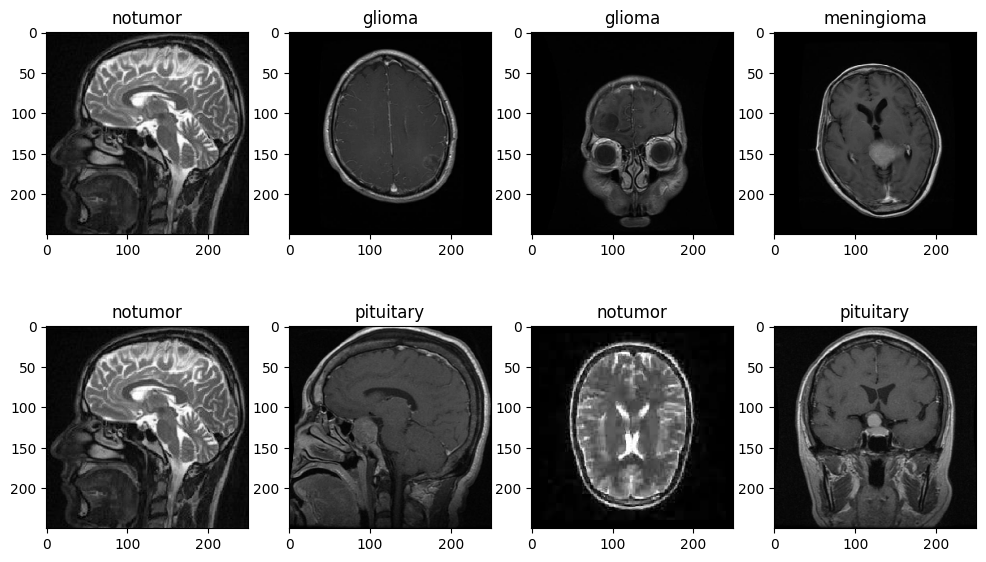

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 7))
axs = axs.ravel()

for i in range(0, 8):
  
    idx = random.randint(0, batch_size - 1)
    axs[i].imshow((x[0][idx]), cmap = 'gray')
    title_idx = x[1][idx]
    title_idx = np.argmax(title_idx, axis = 0)
    title = [key for key, val in class_indices.items() if val == title_idx]
    axs[i].set_title(title[0])

In [ ]:
folders = [folder for folder in os.listdir(train_folder[0]) if os.path.isdir(os.path.join(train_folder[0], folder))]

glioma_total = len(os.listdir(os.path.join(train_folder[0], folders[0])))
meningioma_total = len(os.listdir(os.path.join(train_folder[0], folders[1])))
pituitary_total = len(os.listdir(os.path.join(train_folder[0], folders[2])))
no_total = len(os.listdir(os.path.join(train_folder[0], folders[3])))

variables = ['glioma tumor', 'meningioma tumor', 'no tumor', 'pituitary tumor']
values = [glioma_total, meningioma_total, no_total, pituitary_total]

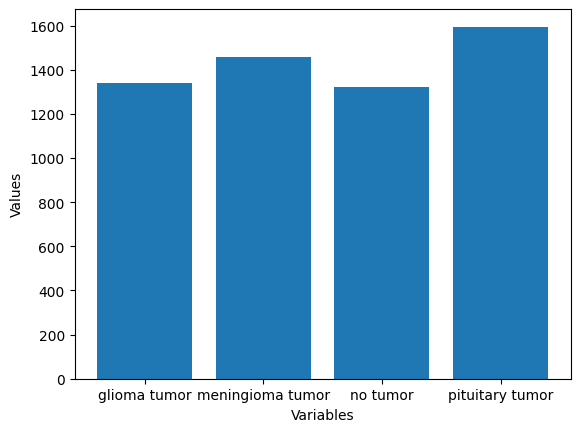

In [ ]:
plt.bar(variables, values)

plt.xlabel('Variables')
plt.ylabel('Values')

plt.show()

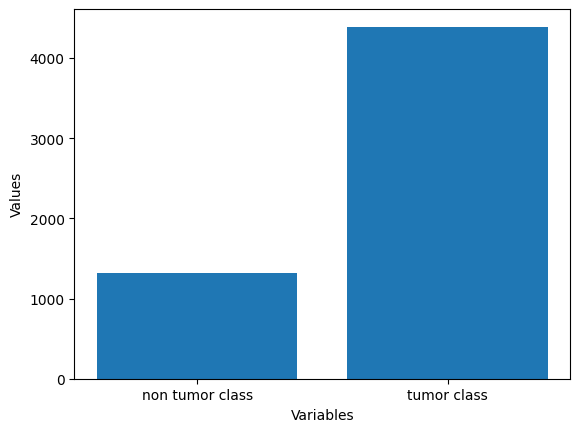

In [ ]:
plt.bar(['non tumor class', 'tumor class'], [no_total, (glioma_total + meningioma_total + pituitary_total)])

plt.xlabel('Variables')
plt.ylabel('Values')

plt.show()

In [ ]:
print("Percentage of glioma tumor images: {:.2f}".format(glioma_total / 3305   * 100))
print("Percentage of meningioma tumor images: {:.2f}".format(meningioma_total / 3305   * 100))
print("Percentage of no tumor images: {:.2f}".format(no_total / 3305   * 100))
print("Percentage of pituitary tumor images: {:.2f}".format(pituitary_total / 3305   * 100))

Percentage of glioma tumor images: 40.51
Percentage of meningioma tumor images: 44.08
Percentage of no tumor images: 39.97
Percentage of pituitary tumor images: 48.26


**Model 1**
Used for previous training. Changes made: Added dropouts after maxpool layers.
Low variance of val loss but overfitting.

In [ ]:
i = Input(shape = (width, height, channels))

x = Conv2D(32, (7, 7), strides = (2, 2), padding = 'same', activation = 'relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D((4, 4))(x)
x = Dropout(0.4)(x)

x = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((4, 4))(x)
x = Dropout(0.4)(x)

#x = MaxPooling2D((4, 4))(x)

x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

#x = GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(1024, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(4, activation = 'softmax')(x)

model = Model(i, x)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['accuracy'])

**Model 2**
High variance for val losses.

In [ ]:
i = Input(shape = (width, height, channels))

x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(i)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)


x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3))(x)
x = Dropout(0.4)(x)

x = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((4, 4))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.7)(x)
x = Dense(4, activation = 'softmax')(x)

model = Model(i, x)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 125, 125, 32)      1600      
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        100416

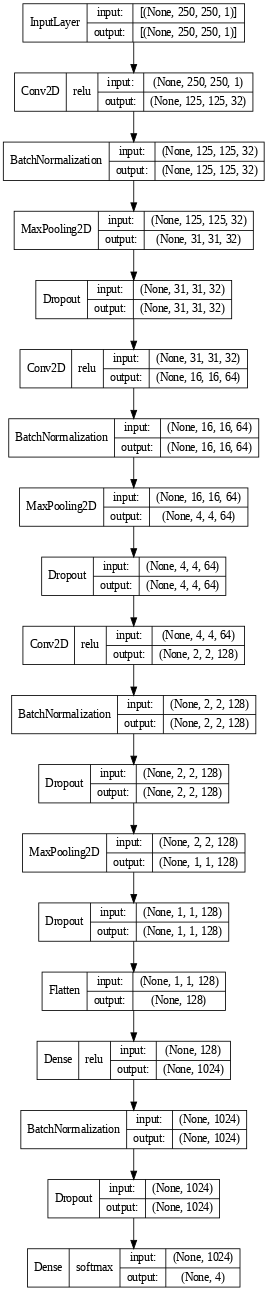

In [ ]:
plot_model(model, show_shapes = True, show_layer_names = False, dpi = 60, show_layer_activations = True, rankdir = 'TB')

In [ ]:
#early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(train_generator, validation_data = validation_generator, epochs = 80)

Epoch 1/80
143/143 [==============================] - 32s 126ms/step - loss: 1.7728 - accuracy: 0.3868 - val_loss: 2.6279 - val_accuracy: 0.2314
Epoch 2/80
143/143 [==============================] - 18s 129ms/step - loss: 1.4186 - accuracy: 0.4957 - val_loss: 3.5868 - val_accuracy: 0.2393
Epoch 3/80
143/143 [==============================] - 18s 128ms/step - loss: 1.3226 - accuracy: 0.5423 - val_loss: 3.5498 - val_accuracy: 0.3348
Epoch 4/80
143/143 [==============================] - 17s 120ms/step - loss: 1.2181 - accuracy: 0.5684 - val_loss: 2.7685 - val_accuracy: 0.4706
Epoch 5/80
143/143 [==============================] - 17s 118ms/step - loss: 1.1510 - accuracy: 0.5885 - val_loss: 1.9496 - val_accuracy: 0.4812
Epoch 6/80
143/143 [==============================] - 17s 120ms/step - loss: 1.0671 - accuracy: 0.6106 - val_loss: 1.6988 - val_accuracy: 0.4987
Epoch 7/80
143/143 [==============================] - 18s 125ms/step - loss: 1.0402 - accuracy: 0.6261 - val_loss: 1.5559 - val_ac

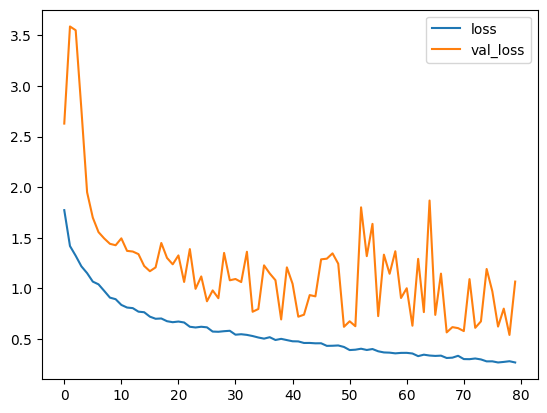

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

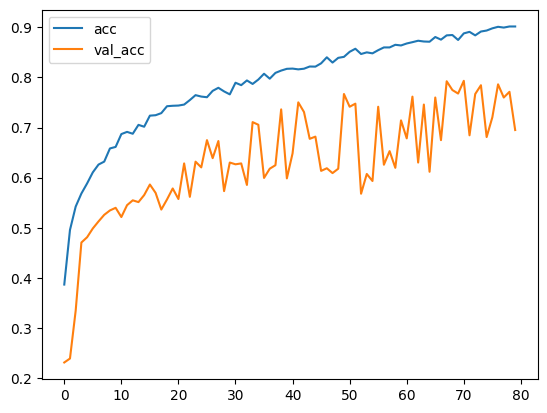

In [ ]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()

In [ ]:
tumor_true = []
tumor_false = []

for i in range(0, len(y_true)):

  if y_true[i] != 2:

    tumor_true.append(y_true[i])
  
  else:

    tumor_false.append(y_true[i])

In [ ]:
tumor_true_pred = []
tumor_false_pred = []

for i in range(0, len(y_pred)):

  if y_pred[i] != 2:

    tumor_true_pred.append(y_pred[i])
  
  else:

    tumor_false_pred.append(y_pred[i])

In [ ]:
print(len(tumor_true), len(tumor_false), len(tumor_true_pred), len(tumor_false_pred))

822 319 957 184


In [ ]:
test_folder = glob.glob('/content/Testing')

testgen = ImageDataGenerator(rescale = 1./255,
                             )

test_generator = testgen.flow_from_directory(
    directory = test_folder[0],
    target_size = (width, height),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 1311 images belonging to 4 classes.


In [ ]:
test_pred_prob = model.predict(test_generator)
test_pred = np.argmax(test_pred_prob, axis = 1)
test_true = test_generator.classes

41/41 [==============================] - 4s 102ms/step


In [ ]:
precision = precision_score(test_pred, test_true, average = None)[2]
recall = recall_score(test_pred, test_true, average = None)[2]
f1 = f1_score(test_pred, test_true, average = None)[2]

In [ ]:
print("Scores for no tumor class: \nPrecision score is {precision:.2f}, recall score is {recall:.2f} and f1 score is {f1:.2f}".format(precision = precision, recall = recall, f1 = f1))

Scores for no tumor class: 
Precision score is 0.87, recall score is 0.95 and f1 score is 0.91


In [ ]:
class_index = [0, 1, 3]

for index in class_index:
  title = [key for key, val in class_indices.items()]
  precision = precision_score(test_pred, test_true, average = None)[index]
  recall = recall_score(test_pred, test_true, average = None)[index]
  f1 = f1_score(test_pred, test_true, average = None)[index]
  print('Scores for {index_class} class: \nPrecision score is {precision:.2f}, recall score is {recall:.2f} and f1 score is {f1:.2f}'.format(index_class = title[index], precision = precision, recall = recall, f1 = f1))
  print('\n')

Scores for glioma class: 
Precision score is 0.95, recall score is 0.67 and f1 score is 0.78


Scores for meningioma class: 
Precision score is 0.28, recall score is 0.83 and f1 score is 0.42


Scores for pituitary class: 
Precision score is 0.98, recall score is 0.72 and f1 score is 0.83




In [ ]:
files = []
predictions = []
labels = []
tumor_prediction = []
tumor_actual = []

for filename in test_generator.filenames:
  files.append(filename)

for prediction in test_pred:
  predictions.append(variables[prediction])

  if prediction != 2:
    tumor_prediction.append('True')
  else:
    tumor_prediction.append('False')    

for label in test_true:
  labels.append(variables[label])

  if label != 2:
    tumor_actual.append('True')
  else:
    tumor_actual.append('False') 

data = {
    'filename' : files,
    'prediction' : predictions,
    'label' : labels,
    'tumor flag prediction' : tumor_prediction,
    'tumor flag actual' : tumor_actual
}

test_df = pd.DataFrame(data)

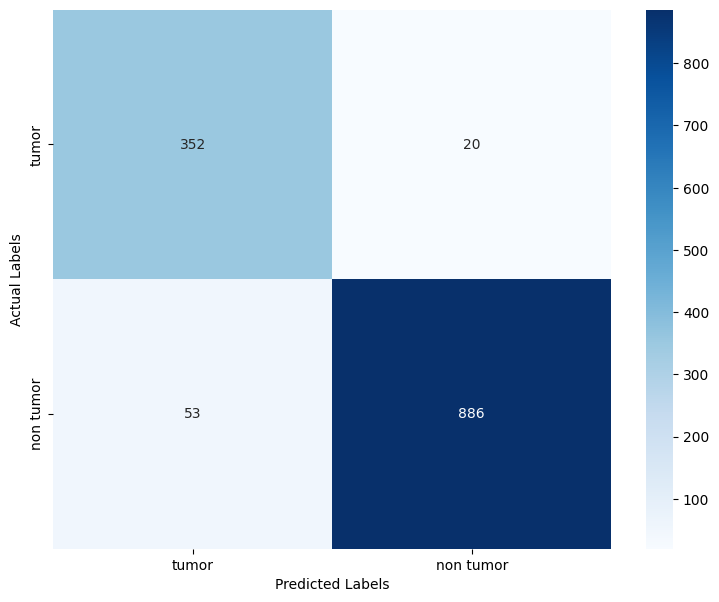

In [ ]:
cm = confusion_matrix(tumor_prediction, tumor_actual, normalize = None)

cm = cm.astype(int)

fig, ax = plt.subplots(figsize = (9, 7))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

ax.set_xticklabels(['tumor', 'non tumor'])
ax.set_yticklabels(['tumor', 'non tumor'])

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')


plt.show()

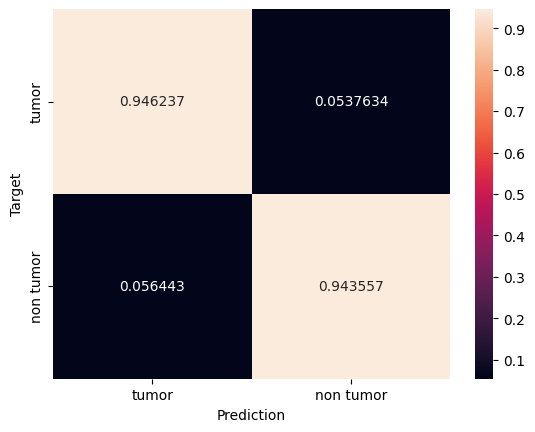

In [ ]:
cm = confusion_matrix(tumor_prediction, tumor_actual, normalize = 'true')

def plot_cm(cm):
  classes = ['tumor', 'non tumor']
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  ax = sns.heatmap(df_cm, annot = True, fmt = 'g')
  ax.set_xlabel('Prediction')
  ax.set_ylabel('Target')

plot_cm(cm)

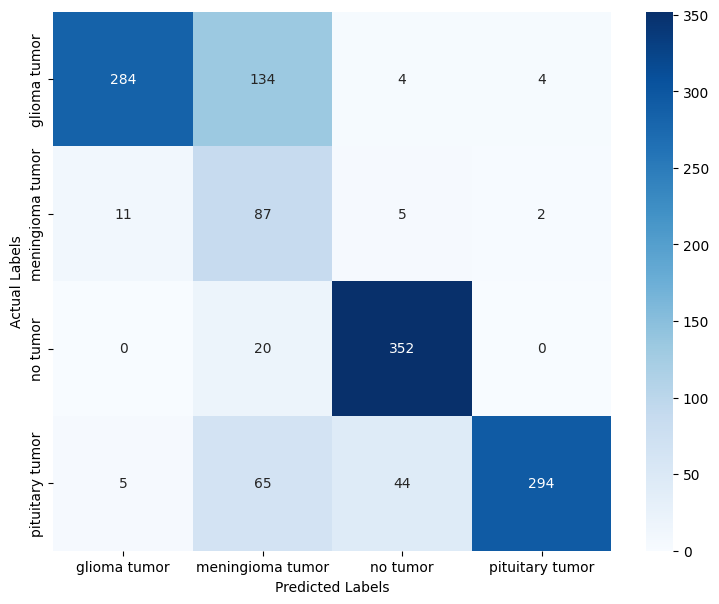

In [ ]:
cm = confusion_matrix(predictions, labels, normalize = None)

cm = cm.astype(int)

fig, ax = plt.subplots(figsize = (9, 7))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

ax.set_xticklabels(variables)
ax.set_yticklabels(variables)

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')


plt.show()

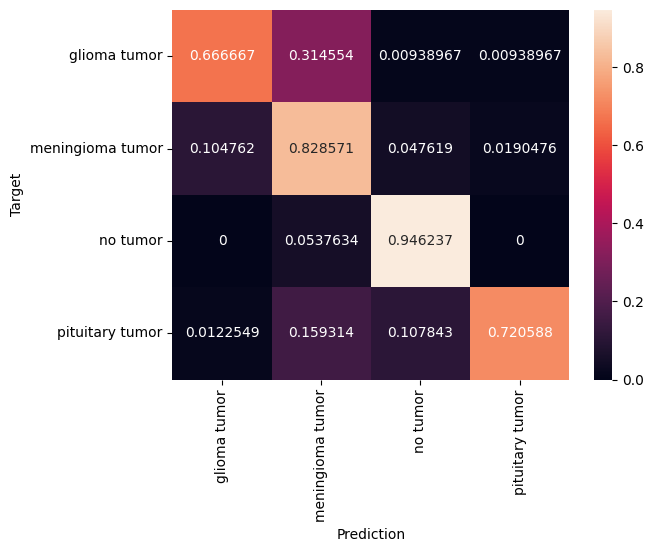

In [ ]:
cm = confusion_matrix(predictions, labels, normalize = 'true')

def plot_cm(cm):
  classes = ['glioma tumor', 'meningioma tumor', 'no tumor', 'pituitary tumor']
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  ax = sns.heatmap(df_cm, annot = True, fmt = 'g')
  ax.set_xlabel('Prediction')
  ax.set_ylabel('Target')

plot_cm(cm)

In [ ]:
test_df

,filename,prediction,label,tumor flag prediction,tumor flag actual
0,glioma/Te-glTr_0000.jpg,glioma tumor,glioma tumor,True,True
1,glioma/Te-glTr_0001.jpg,glioma tumor,glioma tumor,True,True
2,glioma/Te-glTr_0002.jpg,glioma tumor,glioma tumor,True,True
3,glioma/Te-glTr_0003.jpg,glioma tumor,glioma tumor,True,True
4,glioma/Te-glTr_0004.jpg,glioma tumor,glioma tumor,True,True
...,...,...,...,...,...
1306,pituitary/Te-pi_0295.jpg,pituitary tumor,pituitary tumor,True,True
1307,pituitary/Te-pi_0296.jpg,pituitary tumor,pituitary tumor,True,True
1308,pituitary/Te-pi_0297.jpg,pituitary tumor,pituitary tumor,True,True
1309,pituitary/Te-pi_0298.jpg,pituitary tumor,pituitary tumor,True,True


In [ ]:
correct_predictions_tumor_class = test_df[test_df['tumor flag prediction'] == test_df['tumor flag actual']]
incorrect_predictions_tumor_class = test_df[test_df['tumor flag prediction'] != test_df['tumor flag actual']]

correct_predictions_tumor_type = test_df[test_df['prediction'] == test_df['label']]
incorrect_predictions_tumor_type = test_df[test_df['prediction'] != test_df['label']]

In [ ]:
correct_predictions_tumor_class

,filename,prediction,label,tumor flag prediction,tumor flag actual
0,glioma/Te-glTr_0000.jpg,glioma tumor,glioma tumor,True,True
1,glioma/Te-glTr_0001.jpg,glioma tumor,glioma tumor,True,True
2,glioma/Te-glTr_0002.jpg,glioma tumor,glioma tumor,True,True
3,glioma/Te-glTr_0003.jpg,glioma tumor,glioma tumor,True,True
4,glioma/Te-glTr_0004.jpg,glioma tumor,glioma tumor,True,True
...,...,...,...,...,...
1306,pituitary/Te-pi_0295.jpg,pituitary tumor,pituitary tumor,True,True
1307,pituitary/Te-pi_0296.jpg,pituitary tumor,pituitary tumor,True,True
1308,pituitary/Te-pi_0297.jpg,pituitary tumor,pituitary tumor,True,True
1309,pituitary/Te-pi_0298.jpg,pituitary tumor,pituitary tumor,True,True


In [ ]:
incorrect_predictions_tumor_class

,filename,prediction,label,tumor flag prediction,tumor flag actual
300,meningioma/Te-meTr_0000.jpg,no tumor,meningioma tumor,False,True
310,meningioma/Te-me_0010.jpg,no tumor,meningioma tumor,False,True
319,meningioma/Te-me_0019.jpg,no tumor,meningioma tumor,False,True
320,meningioma/Te-me_0020.jpg,no tumor,meningioma tumor,False,True
331,meningioma/Te-me_0031.jpg,no tumor,meningioma tumor,False,True
...,...,...,...,...,...
956,notumor/Te-no_0350.jpg,pituitary tumor,no tumor,True,False
962,notumor/Te-no_0356.jpg,pituitary tumor,no tumor,True,False
968,notumor/Te-no_0362.jpg,pituitary tumor,no tumor,True,False
1001,notumor/Te-no_0395.jpg,pituitary tumor,no tumor,True,False


In [ ]:
correct_predictions_tumor_type

,filename,prediction,label,tumor flag prediction,tumor flag actual
0,glioma/Te-glTr_0000.jpg,glioma tumor,glioma tumor,True,True
1,glioma/Te-glTr_0001.jpg,glioma tumor,glioma tumor,True,True
2,glioma/Te-glTr_0002.jpg,glioma tumor,glioma tumor,True,True
3,glioma/Te-glTr_0003.jpg,glioma tumor,glioma tumor,True,True
4,glioma/Te-glTr_0004.jpg,glioma tumor,glioma tumor,True,True
...,...,...,...,...,...
1306,pituitary/Te-pi_0295.jpg,pituitary tumor,pituitary tumor,True,True
1307,pituitary/Te-pi_0296.jpg,pituitary tumor,pituitary tumor,True,True
1308,pituitary/Te-pi_0297.jpg,pituitary tumor,pituitary tumor,True,True
1309,pituitary/Te-pi_0298.jpg,pituitary tumor,pituitary tumor,True,True


In [ ]:
incorrect_predictions_tumor_type

,filename,prediction,label,tumor flag prediction,tumor flag actual
30,glioma/Te-gl_0030.jpg,meningioma tumor,glioma tumor,True,True
44,glioma/Te-gl_0044.jpg,meningioma tumor,glioma tumor,True,True
45,glioma/Te-gl_0045.jpg,meningioma tumor,glioma tumor,True,True
46,glioma/Te-gl_0046.jpg,meningioma tumor,glioma tumor,True,True
209,glioma/Te-gl_0209.jpg,pituitary tumor,glioma tumor,True,True
...,...,...,...,...,...
1017,pituitary/Te-piTr_0006.jpg,glioma tumor,pituitary tumor,True,True
1086,pituitary/Te-pi_0075.jpg,glioma tumor,pituitary tumor,True,True
1089,pituitary/Te-pi_0078.jpg,glioma tumor,pituitary tumor,True,True
1199,pituitary/Te-pi_0188.jpg,glioma tumor,pituitary tumor,True,True


In [ ]:
model.save('/content/braintumor.h5')